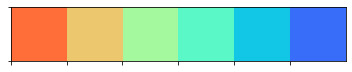

In [1]:
import os, warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# 防止爆显存
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import tensorflow as tf
import gc
import tensorflow.keras.backend as K

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import pandas as pd
from pandas import Series
import numpy as np
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold
import molmap.model

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette("rainbow_r", 6) #PiYG
sns.palplot(color)

from joblib import load, dump

In [2]:
# AA_pro
PCP = pd.read_csv('/raid/hly/vaccin/data/cal_CTD/PCP_61.csv', index_col='properties').index
AApro_dic = pd.read_csv('/raid/hly/umap/single_index/AApro_UMAP.csv', header=0,index_col=0)
AA_pro = AApro_dic.loc[PCP].astype('float')
AA_pro = AA_pro.T
AA_pro = ((AA_pro - AA_pro.min()) / (AA_pro.max() - AA_pro.min())).T #归一化


# get_3d_feat -- our method (老师筛选了31个理化性质，一个aa对应一个值)
def get_3d_feat2(seq):
    n = len(seq)
    # 生成理化性质矩阵
    seq_pro = pd.DataFrame(AA_pro[aa] for aa in seq).T
    seq_pro = seq_pro.values[:, :, None]  #二维变成三维（31， n， 1）
    # 相乘开根号
    mt_pro = np.transpose((seq_pro * np.transpose(seq_pro, [0, 2, 1])), [1, 2, 0]) **.25
    #transpose三维转置。（31，n，1）*（31，1，n）=（31，n，n），再转置成（n，n，31）.
    for k in range(mt_pro.shape[2]):
        for i in range(n):
            for j in range(i):
                if k < 60:                                      ##here
                    mt_pro[i,j,k] = (mt_pro[j,i,k] * mt_pro[j,i,k+1])**.5
                else:
                    mt_pro[i,j,k] = (mt_pro[j,i,k] * mt_pro[j,i,0])**.5
                
    # 生成序列距离矩阵
    pt_dis = np.ones((n,n))
    for i in range(n):
        for j in range(n):
            pt_dis[i][j] = abs(i-j)
    pt_dis = ((pt_dis - 0) / (n-1 - 0)) ## 归一化（最小值为0，最大值为n-1）
    pt_dis = pt_dis[:, :, np.newaxis]  ##（n，n，1）

    # 将序列距离矩阵与理化性质矩阵合并，并放在第一层
    mt = np.concatenate((pt_dis,mt_pro),axis = 2)
    
    x = np.pad(mt, [(0, max_seq_len-n), (0, max_seq_len-n), (0, 0)]) #填充0.令数据集中每条序列对应的Xshape相同。

    return x[ :, :, :, None]


def get_pos_weight(c):
    cnt = [0] * 8
    for i in Y_train:
        if 2<= i < 4:
            cnt[0] = cnt[0] + 1
        if 4<= i < 5:
            cnt[1] = cnt[1] + 1
        if 5 <= i < 6:
            cnt[2] = cnt[2] + 1
        if 6<= i < 7:
            cnt[3] = cnt[3] + 1
        if 7<= i < 8:
            cnt[4] = cnt[4] + 1
        if 8<= i < 9:
            cnt[5] = cnt[5] + 1
        if 9<= i < 10:
            cnt[6] = cnt[6] + 1
        if 10<= i < 12:
            cnt[7] = cnt[7] + 1
    total = sum(cnt)
    for i in range(len(cnt)):
        if cnt[i] != 0:
            cnt[i] = (c * total) / (cnt[i] + c * total)
    return np.array(cnt)


class Inception(tf.keras.layers.Layer):

    def __init__(self, units = 8, strides = 1):
        super(Inception, self).__init__()
        self.conv1 = tf.keras.layers.Conv3D(units, (1,1,1), padding='same', activation = 'relu', strides = strides,kernel_regularizer=tf.keras.regularizers.l2(lamda),
  bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda))
        self.conv2 = tf.keras.layers.Conv3D(units, (3,3,3), padding='same', activation = 'relu', strides = strides,kernel_regularizer=tf.keras.regularizers.l2(lamda),
  bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda))
        self.conv3 = tf.keras.layers.Conv3D(units, (5,5,5), padding='same', activation = 'relu', strides = strides,kernel_regularizer=tf.keras.regularizers.l2(lamda),
  bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda))
        self.concat = tf.keras.layers.Concatenate()

    def call(self, inputs):
        x1 = self.conv1(inputs)
        x2 = self.conv2(inputs)
        x3 = self.conv3(inputs)
        outputs = self.concat([x1, x2, x3])
        return outputs

    def get_config(self): 
        config = {"conv1": self.conv1,"conv2":self.conv2,'conv3':self.conv3}
        base_config = super(Inception, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [3]:
expt_name = 'expt-COV-KN'                                              #here
Train_dir = '/raid/hly/PK-3[2018PLOS]/data/train_data-MID/class_1'   #here
Test_dir = '/raid/hly/PK-3[2018PLOS]/data/PK-3_benchmark_data'

Allele_ls = ['HLA-A_0206','HLA-A_1101','HLA-A_6802','HLA-A_3301']
#'HLA-A_0201','HLA-B_0702','HLA-B_4403','HLA-B_5701','HLA-A_3002','HLA-B_5301','HLA-A_0203'

for Allele in Allele_ls:
    df_train = pd.read_csv(os.path.join(Train_dir,Allele)+'.csv')
    df_test = pd.read_csv(os.path.join(Test_dir,Allele)+'.csv')  
    
    # 创建储存 Allele 结果的文件夹
    res_class = '/raid/hly/PK-3[2018PLOS]/R3-res/'+ expt_name               
    Allele_fold = os.path.join(res_class,Allele)

    if not os.path.exists(Allele_fold) : 
        os.makedirs(Allele_fold)
        os.makedirs(os.path.join(Allele_fold,'loss'))
        os.makedirs(os.path.join(Allele_fold,'models'))
        os.makedirs(os.path.join(Allele_fold,'results'))
        # os.makedirs(os.path.join(Allele_fold,'fig-loss'))
        # os.makedirs(os.path.join(Allele_fold,'fig-pfm'))
        # os.makedirs(os.path.join(Allele_fold,'fig-pred_true')) 

    # 获得训练集和测试集的最大序列长度
    train_max_seq_len = df_train['Description'].apply(len).max()
    test_max_seq_len = df_test['Description'].apply(len).max()
    max_seq_len = max(train_max_seq_len,test_max_seq_len)


    # 生成 X_train + Y_train 
    X_train_name = os.path.join(Allele_fold, Allele+'_X_train_'+'.data')
    if not os.path.exists(X_train_name) :
        X_train = []
        for seq in df_train['Description']:
            X_train.append(get_3d_feat2(seq))
        X_train = np.stack(X_train)
        dump(X_train, X_train_name)
    else:
        X_train = load(X_train_name)
    X_train = X_train.astype('float32')
    Y_train = df_train['Normalized_QM'].values.reshape(-1, 1) 
   
   # 生成 X_test + Y_test 
    X_test_name = os.path.join(Allele_fold, Allele+'_X_test_'+'.data')
    if not os.path.exists(X_test_name) :
        X_test = []
        for seq in df_test['Description']:
            X_test.append(get_3d_feat2(seq))
        X_test = np.stack(X_test)
        dump(X_test, X_test_name)
    else:
        X_test = load(X_test_name)
    X_test = X_test.astype('float32')
    Y_test = df_test['Normalized_QM'].values.reshape(-1, 1) 

    # 确定参数
    inc = (1,3,5)
    lr = 1e-4
    if max_seq_len < 15:
        ks_fir_ls = [(3,3,7),(5,5,9),(9,9,13)]
    else:
        ks_fir_ls = [(3,3,7),(9,9,13),(15,15,19)]
        
    kn_ls = [(48,32,64),(75,50,100)]   #后续改变第二层的kernel number  #,(75,50,100),(96,64,128)
    lamda_ls = [1e-3,1e-6,1e-9]  
    bs = 32
   
   #******************************************
    # R2_ls = []
    task_name = Allele + '_' + expt_name.split('-')[1]
    
    for kn in kn_ls:
        kn_1,kn_2,kn_3 = kn[0],kn[1],kn[2]
        for ks_fir in ks_fir_ls:
            for lamda in lamda_ls:

                # continue 情况
                df_done = pd.read_csv('/raid/hly/PK-3[2018PLOS]/R3-res/done_list.csv')
                exists_name = task_name + '_(lr_%s-bs_%s-lam_%s-ks_[%s,%s]-kn_%s)_' %(lr,bs,lamda,ks_fir,inc,kn)
                if (exists_name +'_results.csv') in (df_done['done_file'].values):
                    continue

                for n in range(2):
            
                    print(exists_name)  

                    # 查看目前最佳 R2
                    result_file = os.path.join(Allele_fold,'results')
                    result_csv = result_file + '/' + task_name + '_results.csv'
                    if os.path.exists(result_csv) :
                        df_exit_res = pd.read_csv(result_csv)
                        best_exit_R2 = df_exit_res['valid_r2'][0]
                    else:
                        best_exit_R2 = [0]
                        
                    lr = lr
                    patience = 50
                    epochs = 600
                    loss= tf.keras.losses.log_cosh     #weighted_loss #tf.keras.losses.mean_squared_error 
                    batch_size = bs

                    df_loss = pd.DataFrame()          
                    results = []


                    model = tf.keras.Sequential([
                    tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
            bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda)),
                    tf.keras.layers.MaxPool3D(), #pool_size = (2,2,2)
                    #here
                    tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
            bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda)),
                    tf.keras.layers.MaxPool3D(), #pool_size = (2,2,2)
                    #here
                    Inception(units=kn_2, strides=1),
                    tf.keras.layers.MaxPool3D(),
                    Inception(units=kn_3, strides=1),
                    tf.keras.layers.GlobalMaxPooling3D(),           #tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(1)
                    ])

                    opt = tf.keras.optimizers.Adam(lr=lr)
                    model.compile(optimizer=opt, loss=loss)

                    performance = molmap.model.cbks.Reg3D_EarlyStoppingAndPerformance((X_train, Y_train), 
                                                                    (X_test, Y_test), 
                                                                patience = patience,
                                                                )

                    model.fit(X_train, Y_train, batch_size=batch_size, 
                            epochs = epochs, verbose = 0, shuffle = True, 
                            validation_data = (X_test, Y_test), callbacks = [performance]) 


                    best_epoch = performance.best_epoch
                    trainable_params = model.count_params()

                    #获取RMSE和R2
                    train_rmse,train_mse,train_mae,train_r,train_r2 = performance.evaluate(X_train, Y_train)            
                    test_rmse,test_mse,test_mae,test_r,test_r2 = performance.evaluate(X_test, Y_test)

                    # R2_ls.append(test_r2)                

                    if test_r2 >= best_exit_R2:

                        #储存loss
                        dfl = pd.DataFrame(performance.history)
                        df_loss = df_loss.append(dfl, ignore_index = True)
                        df_loss.to_csv(os.path.join(os.path.join(Allele_fold,'loss'),  task_name +'_loss.csv'))

                        #整体性结果
                        final_res = {
                                        'train_rmse':np.nanmean(train_rmse), 
                                        'valid_rmse':np.nanmean(test_rmse),  
                                        'train_mse':np.nanmean(train_mse), 
                                        'valid_mse':np.nanmean(test_mse),                      
                                        'train_r2':np.nanmean(train_r2), 
                                        'valid_r2':np.nanmean(test_r2), 
                                        'train_mae':np.nanmean(train_mae), 
                                        'valid_mae':np.nanmean(test_mae),
                                        'train_r':np.nanmean(train_r), 
                                        'valid_r':np.nanmean(test_r),
                                        'trainable params': trainable_params, 
                                        'best_epoch': best_epoch,
                                        'lr' : lr,
                                        'batch_size':bs,
                                        'kernel_size_1':ks_fir,
                                        'kernel_size_incept': inc,
                                        'kernel_number':kn,
                                        'lamda' : lamda
                                        }

                        results.append(final_res)
                        dfr = pd.DataFrame(results)
                        dfr.to_csv(os.path.join(os.path.join(Allele_fold,'results'),  task_name +'_results.csv'))
                        
                        # 保存模型
                        model.save(os.path.join(os.path.join(Allele_fold,'models'),  task_name +'_model_' +'.h5'))

                        # make prediction
                        Y_test_pred = model.predict(X_test)
                        df_pred = pd.DataFrame(Y_test_pred.tolist()).rename(columns={0:'Pred_QM'})
                        df_truepred = pd.merge(df_test,df_pred,how='inner',left_index=True,right_index=True)
                        df_truepred.to_csv(os.path.join(Allele_fold,Allele+'true_pred.csv'))

                        # # 保存 loss_fig
                        # plt.plot(df_loss['loss'])
                        # plt.plot(df_loss['val_loss'])
                        # plt.savefig(os.path.join(os.path.join(Allele_fold,'fig-loss'),  task_name +'_lossfig.png'),bbox_inches='tight', dpi=300)
                        
                        # 删除model
                        del model

                    print('*******************************************************')

                    # 删除缓存
                    del performance
                    gc.collect()
                    K.clear_session()
                    tf.compat.v1.reset_default_graph() # TF graph isn't same as Keras grap
                    
                df_done = pd.read_csv('/raid/hly/PK-3[2018PLOS]/R3-res/done_list.csv')   
                new_donels = df_done['done_file'].append(pd.Series(exists_name +'_results.csv'))
                df_newdone = pd.DataFrame(new_donels,columns=['done_file'])
                df_newdone.to_csv('/raid/hly/PK-3[2018PLOS]/R3-res/done_list.csv')
        


HLA-A_0206_COV_(lr_0.0001-bs_32-lam_0.001-ks_[(3, 3, 7),(1, 3, 5)]-kn_(48, 32, 64))_
epoch: 0001, loss: 0.6592 - val_loss: 0.4357; rmse: 0.2701 - rmse_val: 0.4926;  r2: 0.0634 - r2_val: -0.9371; mae: 0.2243 - mae_val: 0.4147;mse: 0.0730 - mse_val: 0.2426; r: 0.3123 - r_val: 0.5969                                                                                                    
epoch: 0002, loss: 0.3033 - val_loss: 0.3439; rmse: 0.2709 - rmse_val: 0.5110;  r2: 0.0578 - r2_val: -1.0850; mae: 0.2211 - mae_val: 0.4349;mse: 0.0734 - mse_val: 0.2611; r: 0.4092 - r_val: 0.5650                                                                                                    
epoch: 0003, loss: 0.2302 - val_loss: 0.2705; rmse: 0.2534 - rmse_val: 0.4553;  r2: 0.1761 - r2_val: -0.6551; mae: 0.2092 - mae_val: 0.3897;mse: 0.0642 - mse_val: 0.2073; r: 0.4684 - r_val: 0.5773                                                                                                    
epoch: 0004, loss: 0.187

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 12, 12, 62, 96)    101184    
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 6, 6, 31, 96)      0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 6, 6, 31, 96)      1152096   
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 3, 15, 96)      0         
_________________________________________________________________
inception (Inception)        (None, 3, 3, 15, 192)     940224    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 1, 7, 192)      0         
_________________________________________________________________
inception_1 (Inception)      (None, 1, 1, 7, 384)      3